In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [62]:
def show(img, title="", cmap='gray', size=6):
    plt.figure(figsize=(size, size))
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [76]:
# Can be improved with histogram-based detection.
def autocrop_dark_edges(img, threshold_ratio=0.7):
    """
    Automatically removes dark borders from module images.
    threshold_ratio = fraction of mean brightness used to detect dark margin.
    """

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mean_val = gray.mean()

    # Compute row/column brightness
    row_brightness = gray.mean(axis=1)
    col_brightness = gray.mean(axis=0)

    # A row/column is considered border if it is significantly darker
    th = mean_val * threshold_ratio

    # Detect start & end positions where brightness > threshold
    y1 = np.argmax(row_brightness > th)
    y2 = len(row_brightness) - np.argmax(row_brightness[::-1] > th)

    x1 = np.argmax(col_brightness > th)
    x2 = len(col_brightness) - np.argmax(col_brightness[::-1] > th)

    # Crop
    cropped = img[y1:y2, x1:x2]

    return cropped

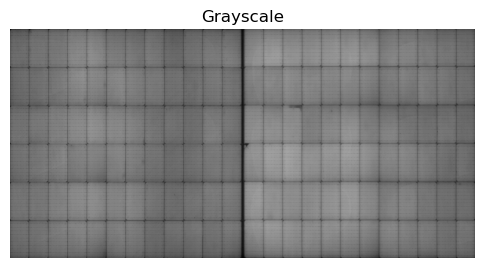

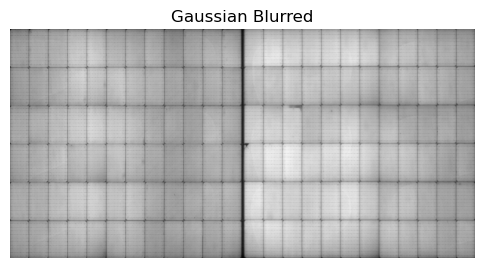

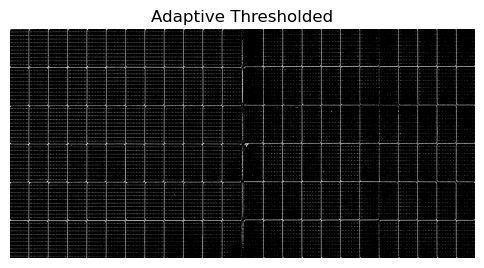

In [77]:
img_path = r"D:\PROGRAMMING\Internships_assignments\ResearchInternIITMandi\Full_modules_datasets\Full modules datasets\18.11.2024\B Grade\WS11249040878796.jpg"
orig = cv2.imread(img_path)
orig = autocrop_dark_edges(orig)
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

show(gray, "Grayscale")

# Smooth slightly to reduce noise
blur = cv2.GaussianBlur(gray, (5,5), 0)
show(blur, "Gaussian Blurred")

# Adaptive threshold (BEST for faint tables)
th = cv2.adaptiveThreshold(
    blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV, 21, 8
)
show(th, "Adaptive Thresholded")

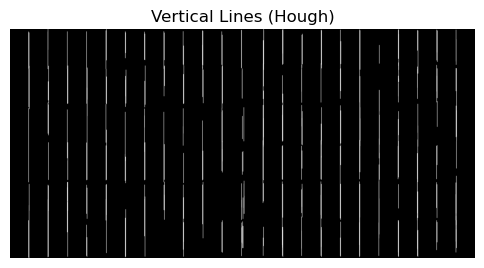

In [78]:
# kernel_v1 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60))
# kernel_v2 = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 60))

# v1 = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel_v1)
# v2 = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel_v2)

# vertical = cv2.bitwise_or(v1, v2)
# show(vertical, "Vertical (Combined Kernels)")


# Detect edges (works well with thresholded image)
edges = cv2.Canny(th, 50, 150, apertureSize=3)

# Hough transform for line detection
lines = cv2.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi/180,
    threshold=120,
    minLineLength=200,   # adjust based on module height
    maxLineGap=20
)

vertical = np.zeros_like(th)

if lines is not None:
    for x1, y1, x2, y2 in lines[:, 0]:
        # Keep only near-vertical lines (angle ~ 90°)
        if abs(x1 - x2) < 5:   # vertical line condition
            cv2.line(vertical, (x1, y1), (x2, y2), 255, 3)

show(vertical, "Vertical Lines (Hough)")


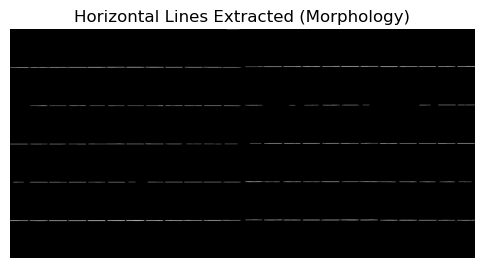

In [87]:
# Horizontal kernel: wide, short
kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 3))
horizontal = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel_h)

show(horizontal, "Horizontal Lines Extracted (Morphology)")


In [88]:
from scipy.signal import find_peaks

# 1D projection profiles
v_proj = vertical.sum(axis=0)
h_proj = horizontal.sum(axis=1)

# Find peaks = real grid lines
v_peaks, _ = find_peaks(v_proj, distance=40, prominence=0.4 * v_proj.max())
h_peaks, _ = find_peaks(h_proj, distance=80, prominence=0.4 * h_proj.max())

print("Vertical peaks:", len(v_peaks))
print("Horizontal peaks:", len(h_peaks))

# These are your final line positions
merged_v = sorted(v_peaks.tolist())
merged_h = sorted(h_peaks.tolist())

Vertical peaks: 23
Horizontal peaks: 5


In [89]:
# def dedupe_positions(arr, gap=5):
#     result = []
#     prev = -999
#     for x in arr:
#         if x - prev > gap:
#             result.append(x)
#             prev = x
#     return result

# v_lines = dedupe_positions(v_lines, gap=10)
# h_lines = dedupe_positions(h_lines, gap=10)

# print("Vertical (clean):", len(v_lines))
# print("Horizontal (clean):", len(h_lines))


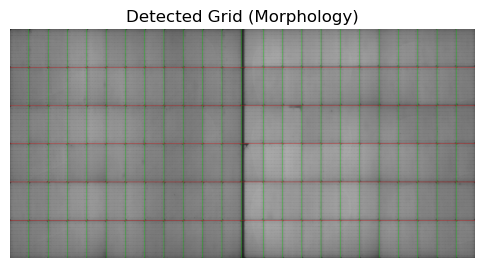

In [90]:
vis = orig.copy()

for x in v_peaks:
    cv2.line(vis, (x, 0), (x, vis.shape[0]), (0, 255, 0), 2)

for y in h_peaks:
    cv2.line(vis, (0, y), (vis.shape[1], y), (0, 0, 255), 2)

show(vis, "Detected Grid (Morphology)")


In [91]:
import numpy as np
from sklearn.cluster import DBSCAN


In [92]:
pts = np.array(v_peaks).reshape(-1, 1)
clusters = DBSCAN(eps=50, min_samples=1).fit(pts)

merged_v = []
for label in set(clusters.labels_):
    cluster_points = pts[clusters.labels_ == label].flatten()
    merged_v.append(int(cluster_points.mean()))

merged_v = sorted(merged_v)
print("Merged vertical lines:", len(merged_v))


Merged vertical lines: 23


In [93]:
pts = np.array(h_peaks).reshape(-1, 1)
clusters = DBSCAN(eps=12, min_samples=1).fit(pts)

merged_h = []
for label in set(clusters.labels_):
    cluster_points = pts[clusters.labels_ == label].flatten()
    merged_h.append(int(cluster_points.mean()))

merged_h = sorted(merged_h)
print("Merged horizontal lines:", len(merged_h))


Merged horizontal lines: 5


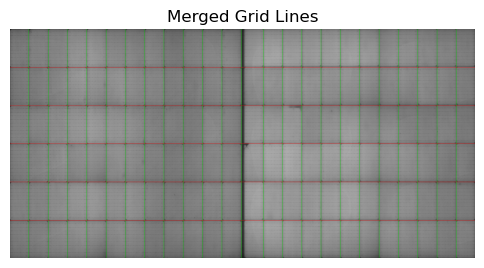

In [94]:
vis2 = orig.copy()

for x in merged_v:
    cv2.line(vis2, (x, 0), (x, vis2.shape[0]), (0, 255, 0), 2)

for y in merged_h:
    cv2.line(vis2, (0, y), (vis2.shape[1], y), (0, 0, 255), 2)

show(vis2, "Merged Grid Lines")


In [95]:
# Add left and right borders
merged_v = [0] + merged_v + [orig.shape[1] - 1]

# Add top and bottom borders
merged_h = [0] + merged_h + [orig.shape[0] - 1]

# Sort to ensure correct ordering
merged_v = sorted(merged_v)
merged_h = sorted(merged_h)

In [96]:
import os

save_dir = "extracted_cells"
os.makedirs(save_dir, exist_ok=True)

cell_count = 0
for r in range(len(merged_h) - 1):
    y1, y2 = merged_h[r], merged_h[r + 1]
    for c in range(len(merged_v) - 1):
        x1, x2 = merged_v[c], merged_v[c + 1]
        
        # Crop cell from original image
        cell = orig[y1:y2, x1:x2]
        
        # Save cell image
        filename = os.path.join(save_dir, f"cell_r{r+1}_c{c+1}.png")
        cv2.imwrite(filename, cell)
        
        cell_count += 1

print(f"Extracted and saved {cell_count} cells to '{save_dir}' folder.")

Extracted and saved 144 cells to 'extracted_cells' folder.
